In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import pandas as pd
import seaborn as sns
pd.set_option('display.max_rows', 40)
!date

Thu Mar  5 14:50:32 PST 2020


# 2010 census demo data. urban vs rural areas: looking for the downward bias in DP counts ala Akee's findings

Akee's talk here: https://vimeo.com/380264104

In [2]:
##Encoding of the AIANHH var:
#0001–4999 Federally recognized American Indian reservation and/or off-reservation trust land
#5000–5499 Hawaiian home land 5500–5999 Oklahoma tribal statistical area
#5500–5999 Oklahoma tribal statistical area
#6000–7999 Alaska Native village statistical area
#8000–8999 Tribal designated statistical area
#9000–9499 State-recognized American Indian reservation
#9500–9998 State designated tribal statistical area 

In [3]:
## Encoding of race vars
# White alone P0030002
# Black or African American alone P0030003
# American Indian and Alaska Native alone P0030004
# Asian alone P0030005
# Native Hawaiian and Other Pacific Islander alone P0030006 
# Some Other Race alone P0030007 
# Two or More Races P0030008 

In [4]:
location_cols = ['STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK']

race_cols = ['P0030001','P0030002','P0030003','P0030004','P0030005','P0030006','P0030007','P0030008'] # race vars
keep_cols = location_cols + race_cols

def my_cols(x):
    if x.startswith('P001'):
        return True
    elif x.startswith(('AIAN','AITS','TTRACT','UA','UR')):
        return True
    else:
        return (x in keep_cols)

In [5]:
%%time

df_dp = pd.read_csv('/home/j/temp/abie/fiftystates2010dhc.csv', usecols=my_cols)
df_dp.backup = df_dp.copy(deep=True)

<string>:2: DtypeWarning: Columns (28,32,33,47,49,50) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 5min 50s, sys: 26.6 s, total: 6min 17s
Wall time: 6min 22s


/share/code/beatrixh/miniconda/envs/beatrix/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [6]:
dta_columns = [x.lower() for x in df_dp.columns] #grab col names as lowercase
dta_columns[-9:] = df_dp.columns[-9:] #coded vars are capitalized
dta_columns #check contents

['state',
 'county',
 'tract',
 'blkgrp',
 'block',
 'aianhh',
 'aianhhfp',
 'aianhhcc',
 'aitsce',
 'aits',
 'aitscc',
 'ttract',
 'ua',
 'uasc',
 'uatype',
 'ur',
 'aianhhns',
 'aitsns',
 'aianhhsc',
 'P0010001',
 'P0030001',
 'P0030002',
 'P0030003',
 'P0030004',
 'P0030005',
 'P0030006',
 'P0030007',
 'P0030008']

In [7]:
%%time

# r = pd.read_stata('/home/j/temp/abie/all50states_2010ur1_all_vars.dta', columns=dta_columns,
#                  chunksize=100_000, convert_missing=True, preserve_dtypes=False)

# df_sf = pd.DataFrame()
# for t in r:
#     print('.', flush=True, end=' ')
#     df_sf = df_sf.append(t[t.block != ''])
# df_sf.shape

# #saved AIAN-relevant vars here; loads faster than the .dta
df_sf = pd.read_csv('/home/j/temp/beatrixh/2020_census/all50states_all_races_02_27_2020.csv')
df_sf.backup = df_sf.copy(deep=True)

<string>:2: DtypeWarning: Columns (7,10,11) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 12.2 s, sys: 4.32 s, total: 16.6 s
Wall time: 17.3 s


/share/code/beatrixh/miniconda/envs/beatrix/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if sys.path[0] == '':


In [8]:
# df_sf.to_csv(r'/home/j/temp/beatrixh/2020_census/all50states_all_races_02_27_2020.csv', index = None, header=True)

In [9]:
df_sf.columns = [x.upper() for x in df_sf.columns]
df_sf.columns

Index(['STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK', 'AIANHH', 'AIANHHFP',
       'AIANHHCC', 'AITSCE', 'AITS', 'AITSCC', 'TTRACT', 'UA', 'UASC',
       'UATYPE', 'UR', 'AIANHHNS', 'AITSNS', 'AIANHHSC', 'P0010001',
       'P0030001', 'P0030002', 'P0030003', 'P0030004', 'P0030005', 'P0030006',
       'P0030007', 'P0030008'],
      dtype='object')

In [10]:
# df_sf = df_sf.drop('UASC', axis=1)
df_dp = df_dp.drop('UASC', axis=1) #this is just NANs

In [11]:
location_cols = ['STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK', 'AIANHH']

In [12]:
block_level = pd.merge(df_sf[df_sf.BLOCK.notnull()],
                       df_dp[df_dp.BLOCK.notnull()][location_cols + race_cols + ['P0010001']],
                       left_on=location_cols,
                       right_on=location_cols,
                       suffixes=('_SF', '_DP'))

In [13]:
# make sure no one is double counted or lost; us pop should be around 308.7 mil (accoding to 2010 census report)
print(f'total population sum: {block_level.P0010001_SF.sum()}')
print(f'total population DP sum: {block_level.P0010001_DP.sum()}')
print(f'total population sum: {block_level.P0030001_SF.sum()}')

total population sum: 308143815
total population DP sum: 308143815
total population sum: 308143815


In [14]:
#that's 7e5 missing. by race is it even?
print(f'total white alone sum (223.6 mil?): {block_level.P0030002_SF.sum()}')
print(f'total black alone sum (42.02 mil?): {block_level.P0030003_SF.sum()}')
print(f'total asian alone sum (17.3 mil?): {block_level.P0030005_SF.sum()}')
print(f'native hawaiian and other pacific islander: {block_level.P0030006_SF.sum()}')
print(f'pct total of expected: {block_level.P0010001_SF.sum()/308.7e6}')
print(f'pct white of expected: {block_level.P0030002_SF.sum()/223.6e6}')
print(f'pct black of expected: {block_level.P0030003_SF.sum()/38_929_319}')
print(f'pct asian of expected: {block_level.P0030005_SF.sum()/14_674_252}')
print(f'pct native hawaiian and other pacific islander of expected: {block_level.P0030006_SF.sum()/540_013}')
print(f'pct AIAN of expected: {block_level.P0030004_SF.sum()/2_932_248}')
print(f'pct "some other race" of expected: {block_level.P0030007_SF.sum()/19.1e6}')

total white alone sum (223.6 mil?): 223321794
total black alone sum (42.02 mil?): 38624194
total asian alone sum (17.3 mil?): 14653196
native hawaiian and other pacific islander: 539711
pct total of expected: 0.9981982993197279
pct white of expected: 0.9987557871198569
pct black of expected: 0.9921620771223869
pct asian of expected: 0.9985651057375872
pct native hawaiian and other pacific islander of expected: 0.9994407542040654
pct AIAN of expected: 0.9992909876654362
pct "some other race" of expected: 0.9991096335078534


In [103]:
# oh oops. i was missing DC, which had pop of 601_723
print(f'total population sum incl DC should be 308,745,538: {block_level.P0030001_SF.sum()+601_723}')

total population sum incl DC should be 308,745,538: 308745538


In [13]:
# now need to check whether or not "total us population" includes federal reservations:
df_dp[(df_dp.AIANHH!=9999)&df_dp.AIANHH.notnull()].P0010001.sum()

86619805

In [14]:
df_dp[(df_dp.AIANHH!=9999)&df_dp.AIANHH.notnull() & df_dp.BLOCK.isnull()]

,STATE,COUNTY,TRACT,BLKGRP,BLOCK,AIANHH,AIANHHFP,AIANHHCC,AITSCE,AITS,...,AIANHHSC,P0010001,P0030001,P0030002,P0030003,P0030004,P0030005,P0030006,P0030007,P0030008
49682,2,13.0,100.0,NaN,NaN,6030.0,1095.0,E1,NaN,NaN,...,NaN,1008,1008,272,136,80,371,26,31,92
49683,2,13.0,100.0,NaN,NaN,6195.0,5980.0,E1,NaN,NaN,...,NaN,0,0,0,0,0,0,0,0,0
49684,2,13.0,100.0,NaN,NaN,6500.0,24675.0,E1,NaN,NaN,...,NaN,24,24,0,4,0,20,0,0,0
49685,2,13.0,100.0,NaN,NaN,6735.0,39415.0,E1,NaN,NaN,...,NaN,913,913,139,7,337,310,6,29,85
49686,2,13.0,100.0,NaN,NaN,7025.0,52945.0,E1,NaN,NaN,...,NaN,79,79,0,0,55,18,0,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13717532,56,NaN,NaN,NaN,NaN,4610.0,84200.0,D8,NaN,NaN,...,NaN,8517,8517,2242,13,5963,13,0,59,227
13717533,56,NaN,NaN,NaN,NaN,4610.0,84200.0,D8,NaN,NaN,...,NaN,8482,8482,7240,26,822,38,0,126,230
13717534,56,NaN,NaN,NaN,NaN,4610.0,84200.0,D8,NaN,NaN,...,NaN,9164,9164,7780,14,886,17,0,104,363
13717535,56,NaN,NaN,NaN,NaN,4610.0,84200.0,D5,NaN,NaN,...,NaN,0,0,0,0,0,0,0,0,0


In [15]:
#does every row have a state?
df_dp[df_dp.STATE.isnull()].shape

(0, 27)

In [114]:
# things to check:
# by county, by state, by tract, by blkgpr, by block: check urban v rural aian
# by reservation, urban v rural aian
# off reservation, urban v rural aian

In [115]:
# first: by county, urban v rural aian
rural_block_level = block_level[block_level.UR=='R']
urban_block_level = block_level[block_level.UR=='U']

In [116]:
race_vars = [str(i) + '_SF' for i in race_cols + ['P0010001']] + [str(i) + '_DP' for i in race_cols + ['P0010001']]

In [117]:
rural_county_level = rural_block_level.groupby(['STATE','COUNTY'])[race_vars].apply(lambda x : x.astype(int).sum())
urban_county_level = urban_block_level.groupby(['STATE','COUNTY'])[race_vars].apply(lambda x : x.astype(int).sum())

# County level: change in AIAN urban pop (SF vs DP)

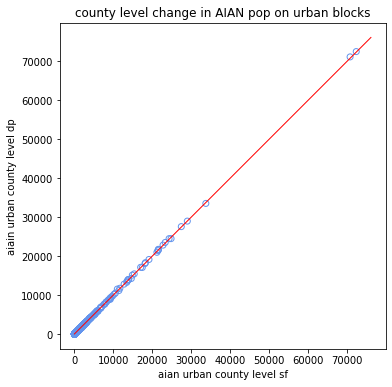

In [62]:
# 
x = urban_county_level[["P0030004_SF"]] #aian urban county level sf
y = urban_county_level[["P0030004_DP"]] #aian urban county level dp

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('aian urban county level sf')
plt.ylabel('aiain urban county level dp')
plt.title('county level change in AIAN pop on urban blocks')

plt.show()

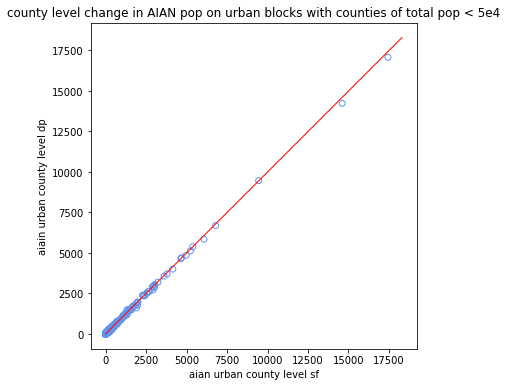

In [65]:
# 
x = urban_county_level[(urban_county_level.P0010001_SF < 5e4)][["P0030004_SF"]] #aian urban county level sf
y = urban_county_level[(urban_county_level.P0010001_SF < 5e4)][["P0030004_DP"]] #aiain urban county level dp

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('aian urban county level sf')
plt.ylabel('aiain urban county level dp')
plt.title('county level change in AIAN pop on urban blocks with counties of total pop < 5e4')

plt.show()

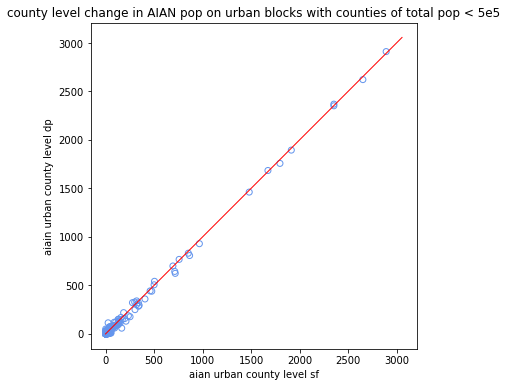

In [66]:
# 
x = urban_county_level[(urban_county_level.P0010001_SF < 5e3)][["P0030004_SF"]] #aian urban county level sf
y = urban_county_level[(urban_county_level.P0010001_SF < 5e3)][["P0030004_DP"]] #aiain urban county level dp

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('aian urban county level sf')
plt.ylabel('aiain urban county level dp')
plt.title('county level change in AIAN pop on urban blocks with counties of total pop < 5e5')

plt.show()

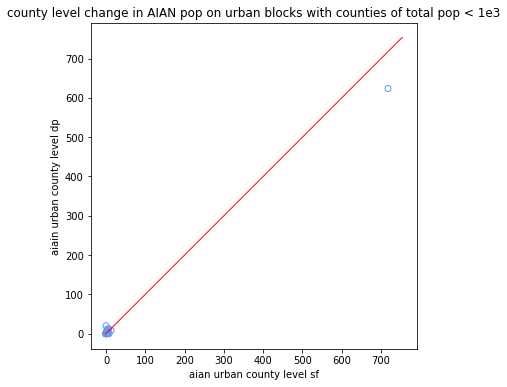

In [118]:
# 
x = urban_county_level[(urban_county_level.P0010001_SF < 1e3)][["P0030004_SF"]] #aian urban county level sf
y = urban_county_level[(urban_county_level.P0010001_SF < 1e3)][["P0030004_DP"]] #aiain urban county level dp

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('aian urban county level sf')
plt.ylabel('aiain urban county level dp')
plt.title('county level change in AIAN pop on urban blocks with counties of total pop < 1e3')

plt.show()

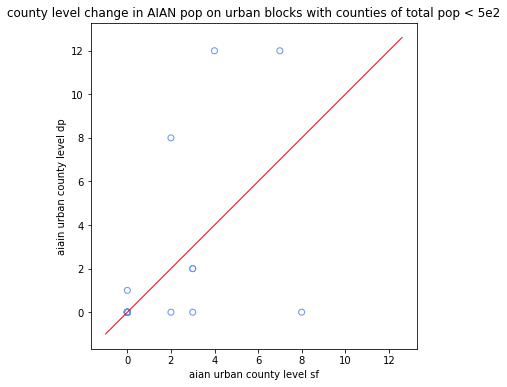

In [70]:
# 
x = urban_county_level[(urban_county_level.P0010001_SF < 5e2)][["P0030004_SF"]] #aian urban county level sf
y = urban_county_level[(urban_county_level.P0010001_SF < 5e2)][["P0030004_DP"]] #aiain urban county level dp

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('aian urban county level sf')
plt.ylabel('aiain urban county level dp')
plt.title('county level change in AIAN pop on urban blocks with counties of total pop < 5e2')

plt.show()

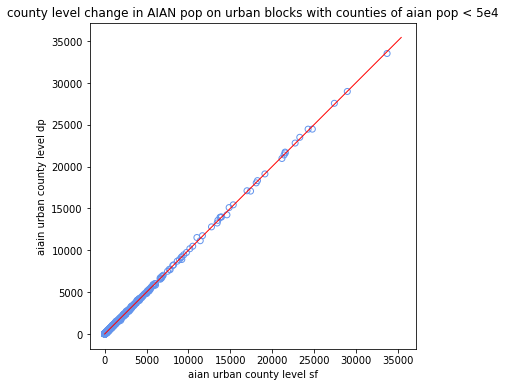

In [82]:
# 
x = urban_county_level[(urban_county_level.P0030004_SF < 5e4)][["P0030004_SF"]] #aian urban county level sf
y = urban_county_level[(urban_county_level.P0030004_SF < 5e4)][["P0030004_DP"]] #aiain urban county level dp

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('aian urban county level sf')
plt.ylabel('aiain urban county level dp')
plt.title('county level change in AIAN pop on urban blocks with counties of aian pop < 5e4')

plt.show()

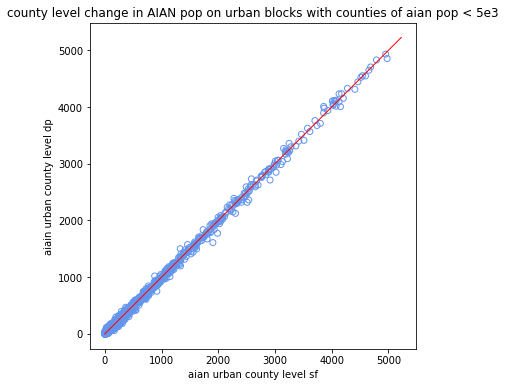

In [83]:
# 
x = urban_county_level[(urban_county_level.P0030004_SF < 5e3)][["P0030004_SF"]] #aian urban county level sf
y = urban_county_level[(urban_county_level.P0030004_SF < 5e3)][["P0030004_DP"]] #aiain urban county level dp

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('aian urban county level sf')
plt.ylabel('aiain urban county level dp')
plt.title('county level change in AIAN pop on urban blocks with counties of aian pop < 5e3')

plt.show()

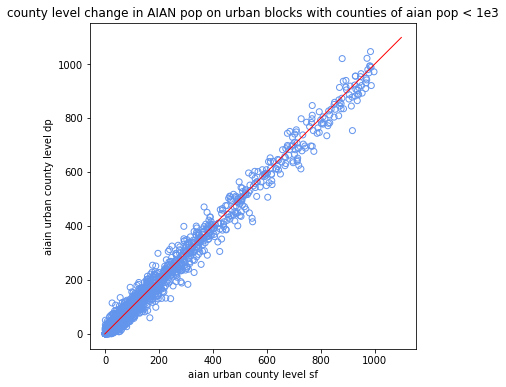

In [177]:
# 
x = urban_county_level[(urban_county_level.P0030004_SF < 1e3)][["P0030004_SF"]] #aian urban county level sf
y = urban_county_level[(urban_county_level.P0030004_SF < 1e3)][["P0030004_DP"]] #aiain urban county level dp

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('aian urban county level sf')
plt.ylabel('aiain urban county level dp')
plt.title('county level change in AIAN pop on urban blocks with counties of aian pop < 1e3')

plt.show()

In [ ]:
## look closre at this level

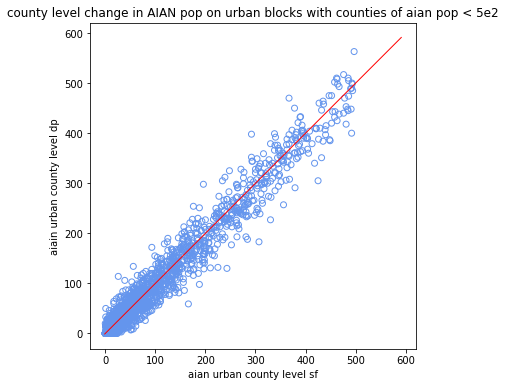

In [85]:
# 
x = urban_county_level[(urban_county_level.P0030004_SF < 5e2)][["P0030004_SF"]] #aian urban county level sf
y = urban_county_level[(urban_county_level.P0030004_SF < 5e2)][["P0030004_DP"]] #aiain urban county level dp

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('aian urban county level sf')
plt.ylabel('aiain urban county level dp')
plt.title('county level change in AIAN pop on urban blocks with counties of aian pop < 5e2')

plt.show()

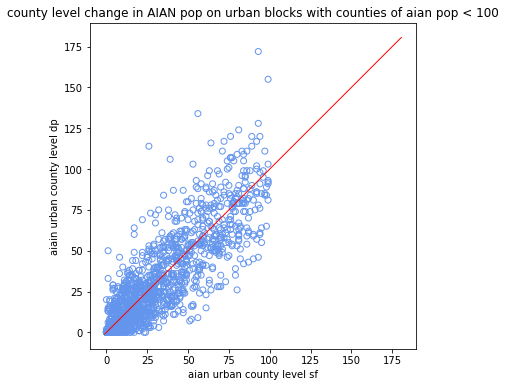

In [86]:
# 
x = urban_county_level[(urban_county_level.P0030004_SF < 1e2)][["P0030004_SF"]] #aian urban county level sf
y = urban_county_level[(urban_county_level.P0030004_SF < 1e2)][["P0030004_DP"]] #aiain urban county level dp

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('aian urban county level sf')
plt.ylabel('aiain urban county level dp')
plt.title('county level change in AIAN pop on urban blocks with counties of aian pop < 100')

plt.show()

# County level: change in AIAN rural pop (SF vs DP)

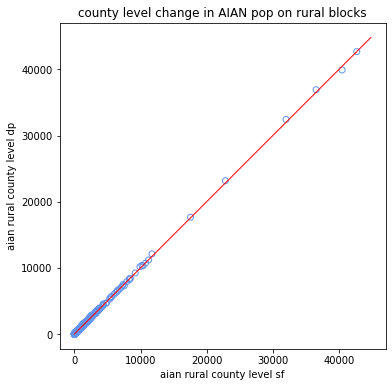

In [81]:
# 
x = rural_county_level[["P0030004_SF"]] #aian rural county level sf
y = rural_county_level[["P0030004_DP"]] #aiain rural county level dp

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('aian rural county level sf')
plt.ylabel('aian rural county level dp')
plt.title('county level change in AIAN pop on rural blocks')

plt.show()

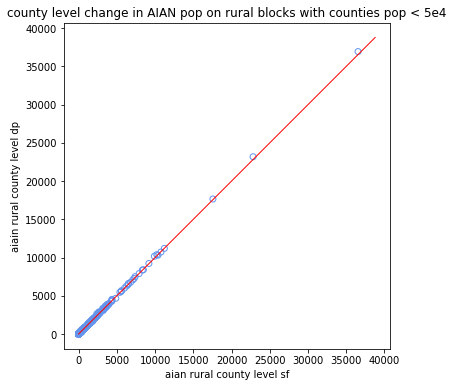

In [127]:
# 
x = rural_county_level[(rural_county_level.P0010001_SF < 5e4)][["P0030004_SF"]] #aian rural county level sf
y = rural_county_level[(rural_county_level.P0010001_SF < 5e4)][["P0030004_DP"]] #aiain rural county level dp

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('aian rural county level sf')
plt.ylabel('aiain rural county level dp')
plt.title('county level change in AIAN pop on rural blocks with counties pop < 5e4')

plt.show()

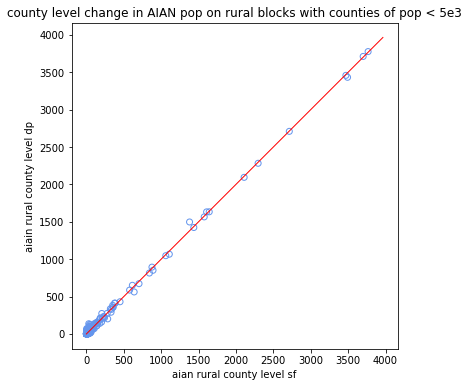

In [128]:
# 
x = rural_county_level[(rural_county_level.P0010001_SF < 5e3)][["P0030004_SF"]] #aian rural county level sf
y = rural_county_level[(rural_county_level.P0010001_SF < 5e3)][["P0030004_DP"]] #aiain rural county level dp

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('aian rural county level sf')
plt.ylabel('aiain rural county level dp')
plt.title('county level change in AIAN pop on rural blocks with counties of pop < 5e3')

plt.show()

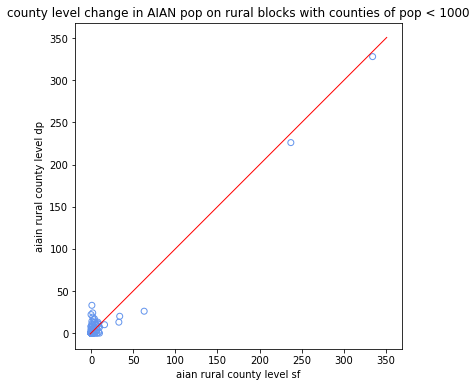

In [129]:
# 
x = rural_county_level[(rural_county_level.P0010001_SF < 1e3)][["P0030004_SF"]] #aian rural county level sf
y = rural_county_level[(rural_county_level.P0010001_SF < 1e3)][["P0030004_DP"]] #aiain rural county level dp

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('aian rural county level sf')
plt.ylabel('aiain rural county level dp')
plt.title('county level change in AIAN pop on rural blocks with counties of pop < 1000')

plt.show()

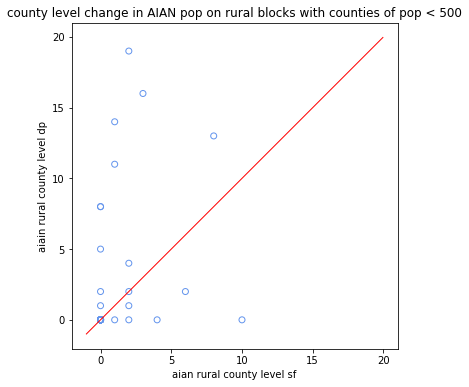

In [130]:
# 
x = rural_county_level[(rural_county_level.P0010001_SF < 500)][["P0030004_SF"]] #aian rural county level sf
y = rural_county_level[(rural_county_level.P0010001_SF < 500)][["P0030004_DP"]] #aiain rural county level dp

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('aian rural county level sf')
plt.ylabel('aiain rural county level dp')
plt.title('county level change in AIAN pop on rural blocks with counties of pop < 500')

plt.show()

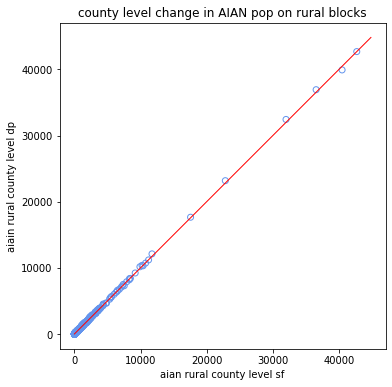

In [133]:
# 
x = rural_county_level[["P0030004_SF"]] #aian rural county level sf
y = rural_county_level[["P0030004_DP"]] #aiain rural county level dp

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('aian rural county level sf')
plt.ylabel('aiain rural county level dp')
plt.title('county level change in AIAN pop on rural blocks')

plt.show()

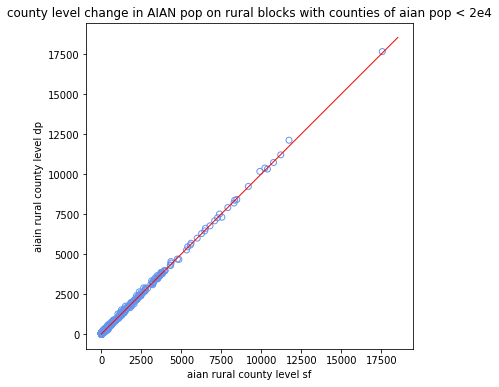

In [135]:
# 
x = rural_county_level[(rural_county_level.P0030004_SF < 2e4)][["P0030004_SF"]] #aian rural county level sf
y = rural_county_level[(rural_county_level.P0030004_SF < 2e4)][["P0030004_DP"]] #aiain rural county level dp

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('aian rural county level sf')
plt.ylabel('aiain rural county level dp')
plt.title('county level change in AIAN pop on rural blocks with counties of aian pop < 2e4')

plt.show()

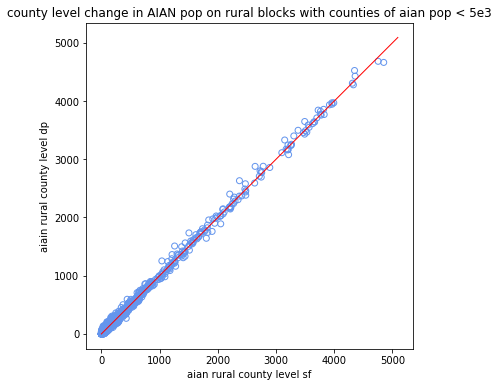

In [136]:
# 
x = rural_county_level[(rural_county_level.P0030004_SF < 5e3)][["P0030004_SF"]] #aian rural county level sf
y = rural_county_level[(rural_county_level.P0030004_SF < 5e3)][["P0030004_DP"]] #aiain rural county level dp

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('aian rural county level sf')
plt.ylabel('aiain rural county level dp')
plt.title('county level change in AIAN pop on rural blocks with counties of aian pop < 5e3')

plt.show()

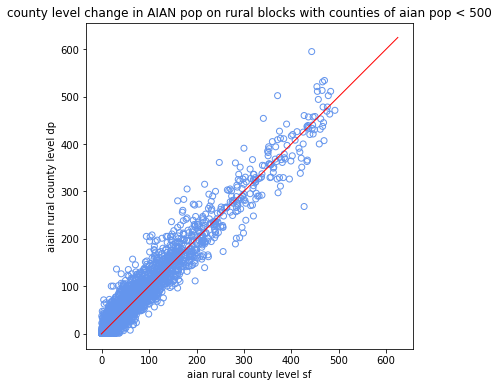

In [137]:
# 
x = rural_county_level[(rural_county_level.P0030004_SF < 500)][["P0030004_SF"]] #aian rural county level sf
y = rural_county_level[(rural_county_level.P0030004_SF < 500)][["P0030004_DP"]] #aiain rural county level dp

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('aian rural county level sf')
plt.ylabel('aiain rural county level dp')
plt.title('county level change in AIAN pop on rural blocks with counties of aian pop < 500')

plt.show()

# look at change at reservation level (same as akee)

In [139]:
block_level_aian = block_level[block_level.AIANHH!=9999]

In [15]:
block_aian_urban = block_level_aian[block_level_aian.UR=="U"]
block_aian_rural = block_level_aian[block_level_aian.UR=="R"]

NameError: name 'block_level_aian' is not defined

In [143]:
block_aian_urban_res = block_level_aian.groupby(['AIANHH'])['P0030004_SF','P0030004_DP',
                                                        'P0010001_SF','P0010001_DP'].apply(lambda x : x.astype(int).sum())
block_aian_rural_res = block_aian_rural.groupby(['AIANHH'])['P0030004_SF','P0030004_DP',
                                                        'P0010001_SF','P0010001_DP'].apply(lambda x : x.astype(int).sum())

/share/code/beatrixh/miniconda/envs/beatrix/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/share/code/beatrixh/miniconda/envs/beatrix/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


In [145]:
block_aian_res = block_level_aian.groupby(['AIANHH'])['P0030004_SF','P0030004_DP',
                                                        'P0010001_SF','P0010001_DP'].apply(lambda x : x.astype(int).sum())

/share/code/beatrixh/miniconda/envs/beatrix/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


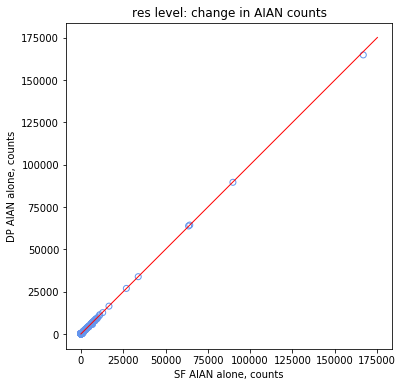

In [178]:
# overall aian on res
x = block_aian_res[["P0030004_SF"]]
y = block_aian_res[["P0030004_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('SF AIAN alone, counts')
plt.ylabel('DP AIAN alone, counts')
plt.title('res level: change in AIAN counts')

plt.show()

In [ ]:
# overall aian on res
x = block_aian_res[["P0030004_SF"]]
y = block_aian_res[["P0030004_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('SF AIAN alone, counts')
plt.ylabel('DP AIAN alone, counts')
plt.title('res level: change in AIAN counts')

plt.show()

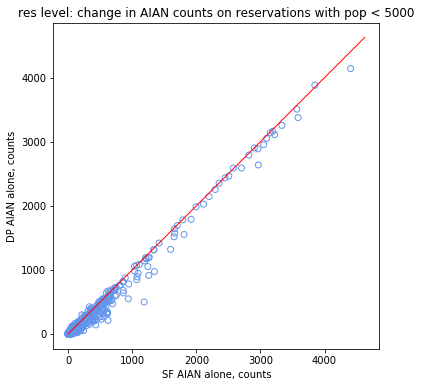

In [180]:
# overall aian on res
x = block_aian_res[(block_aian_res.P0010001_SF < 5e3)][["P0030004_SF"]]
y = block_aian_res[(block_aian_res.P0010001_SF < 5e3)][["P0030004_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('SF AIAN alone, counts')
plt.ylabel('DP AIAN alone, counts')
plt.title('res level: change in AIAN counts on reservations with pop < 5000')

plt.show()

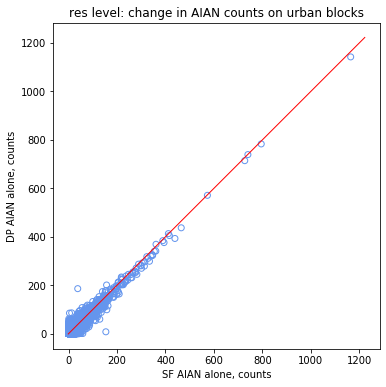

In [152]:
# overall aian on res
x = block_aian_urban[["P0030004_SF"]]
y = block_aian_urban[["P0030004_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('SF AIAN alone, counts')
plt.ylabel('DP AIAN alone, counts')
plt.title('res level: change in AIAN counts on urban blocks')

plt.show()

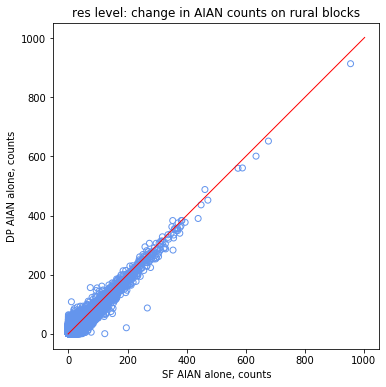

In [153]:
# overall aian on res
x = block_aian_rural[["P0030004_SF"]]
y = block_aian_rural[["P0030004_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('SF AIAN alone, counts')
plt.ylabel('DP AIAN alone, counts')
plt.title('res level: change in AIAN counts on rural blocks')

plt.show()

# County level: change in asian rural pop (SF vs DP)

In [ ]:
# Recall:
## Encoding of race vars
# White alone P0030002
# Black or African American alone P0030003
# American Indian and Alaska Native alone P0030004
# Asian alone P0030005
# Native Hawaiian and Other Pacific Islander alone P0030006 
# Some Other Race alone P0030007 
# Two or More Races P0030008 

In [154]:
# rural_county_level = rural_block_level.groupby(['STATE','COUNTY'])[race_vars].apply(lambda x : x.astype(int).sum())
# urban_county_level = urban_block_level.groupby(['STATE','COUNTY'])[race_vars].apply(lambda x : x.astype(int).sum())

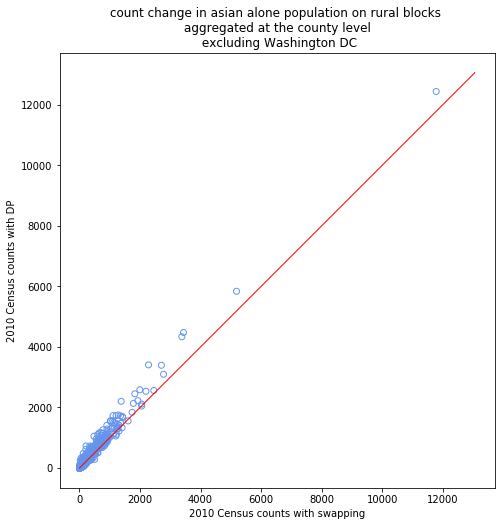

In [202]:
# 
x = rural_county_level[["P0030005_SF"]] #aian rural county level sf
y = rural_county_level[["P0030005_DP"]] #aiain rural county level dp

fig = plt.figure() 
fig.set_size_inches(8,8)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('2010 Census counts with swapping')
plt.ylabel('2010 Census counts with DP')
plt.title('count change in asian alone population on rural blocks \n aggregated at the county level \n excluding Washington DC')

plt.show()

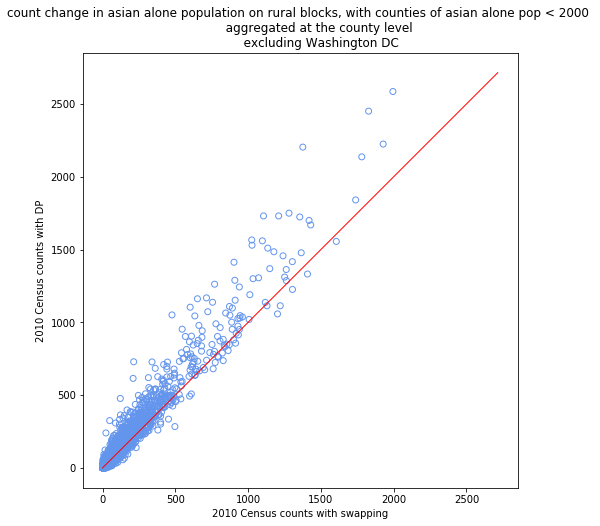

In [203]:
# 
x = rural_county_level[(rural_county_level.P0030005_SF < 2e3)][["P0030005_SF"]] #aian rural county level sf
y = rural_county_level[(rural_county_level.P0030005_SF < 2e3)][["P0030005_DP"]] #aiain rural county level dp

fig = plt.figure() 
fig.set_size_inches(8,8)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('2010 Census counts with swapping')
plt.ylabel('2010 Census counts with DP')
plt.title('count change in asian alone population on rural blocks, with counties of asian alone pop < 2000 \n \
          aggregated at the county level \n \
          excluding Washington DC')

plt.show()

# County level: change in asian urban pop (SF vs DP)

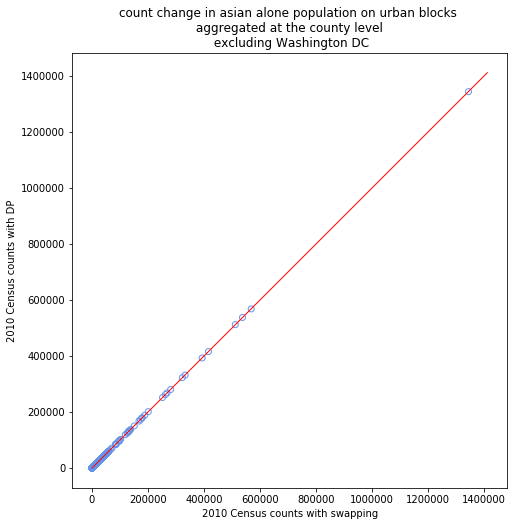

In [196]:
# 
x = urban_county_level[["P0030005_SF"]] #aian rural county level sf
y = urban_county_level[["P0030005_DP"]] #aiain rural county level dp

fig = plt.figure() 
fig.set_size_inches(8,8)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('2010 Census counts with swapping')
plt.ylabel('2010 Census counts with DP')
plt.title('count change in asian alone population on urban blocks \n aggregated at the county level \n excluding Washington DC')

plt.show()

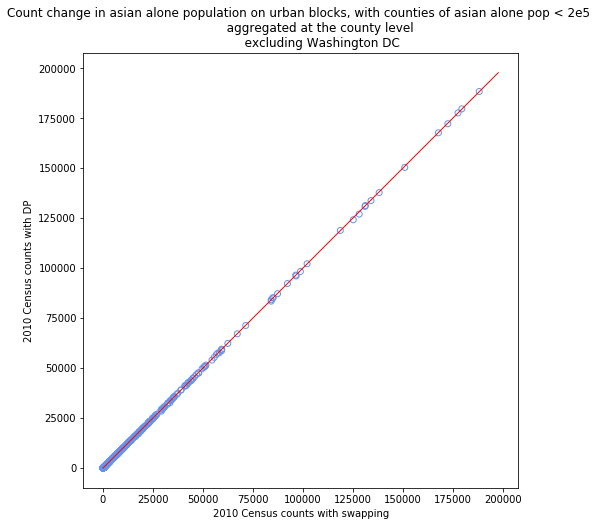

In [199]:
# 
x = urban_county_level[(urban_county_level.P0030005_SF < 2e5)][["P0030005_SF"]] #aian rural county level sf
y = urban_county_level[(urban_county_level.P0030005_SF < 2e5)][["P0030005_DP"]] #aiain rural county level dp

fig = plt.figure() 
fig.set_size_inches(8,8)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('2010 Census counts with swapping')
plt.ylabel('2010 Census counts with DP')
plt.title('Count change in asian alone population on urban blocks, with counties of asian alone pop < 2e5 \n \
          aggregated at the county level \n \
          excluding Washington DC')

plt.show()

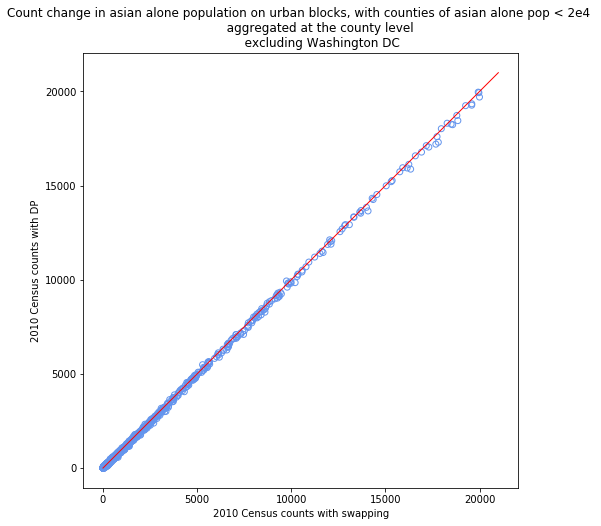

In [200]:
# 
x = urban_county_level[(urban_county_level.P0030005_SF < 2e4)][["P0030005_SF"]] #aian rural county level sf
y = urban_county_level[(urban_county_level.P0030005_SF < 2e4)][["P0030005_DP"]] #aiain rural county level dp

fig = plt.figure() 
fig.set_size_inches(8,8)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('2010 Census counts with swapping')
plt.ylabel('2010 Census counts with DP')
plt.title('Count change in asian alone population on urban blocks, with counties of asian alone pop < 2e4 \n \
          aggregated at the county level \n \
          excluding Washington DC')

plt.show()

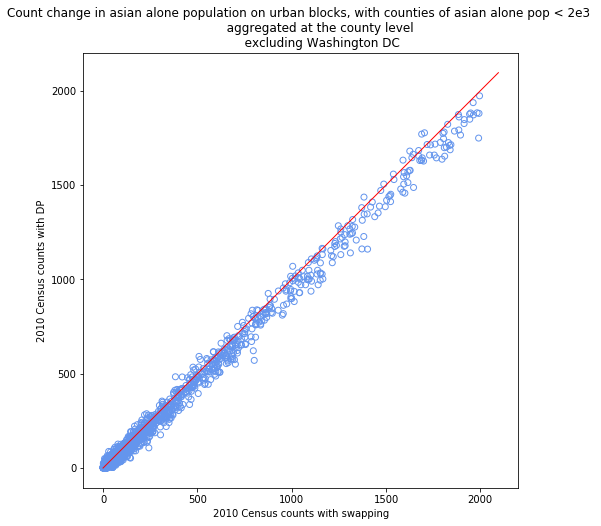

In [201]:
# 
x = urban_county_level[(urban_county_level.P0030005_SF < 2e3)][["P0030005_SF"]] #aian rural county level sf
y = urban_county_level[(urban_county_level.P0030005_SF < 2e3)][["P0030005_DP"]] #aiain rural county level dp

fig = plt.figure() 
fig.set_size_inches(8,8)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('2010 Census counts with swapping')
plt.ylabel('2010 Census counts with DP')
plt.title('Count change in asian alone population on urban blocks, with counties of asian alone pop < 2e3 \n \
          aggregated at the county level \n \
          excluding Washington DC')

plt.show()

# County level: change in black rural pop (SF vs DP)

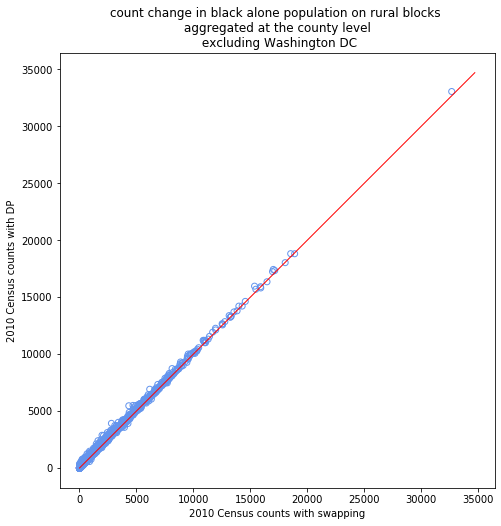

In [204]:
# 
x = rural_county_level[["P0030003_SF"]] #aian rural county level sf
y = rural_county_level[["P0030003_DP"]] #aiain rural county level dp

fig = plt.figure() 
fig.set_size_inches(8,8)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('2010 Census counts with swapping')
plt.ylabel('2010 Census counts with DP')
plt.title('count change in black alone population on rural blocks \n aggregated at the county level \n excluding Washington DC')

plt.show()

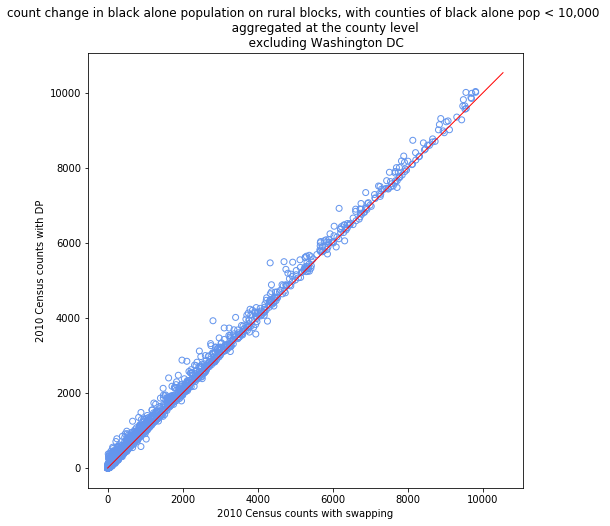

In [208]:
# 
x = rural_county_level[(rural_county_level.P0030003_SF < 1e4)][["P0030003_SF"]] #aian rural county level sf
y = rural_county_level[(rural_county_level.P0030003_SF < 1e4)][["P0030003_DP"]] #aiain rural county level dp

fig = plt.figure() 
fig.set_size_inches(8,8)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('2010 Census counts with swapping')
plt.ylabel('2010 Census counts with DP')
plt.title('count change in black alone population on rural blocks, with counties of black alone pop < 10,000 \n \
          aggregated at the county level \n \
          excluding Washington DC')

plt.show()

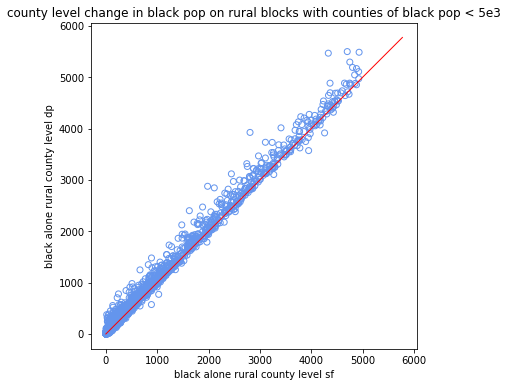

In [167]:
# 
x = rural_county_level[(rural_county_level.P0030003_SF < 5e3)][["P0030003_SF"]] 
y = rural_county_level[(rural_county_level.P0030003_SF < 5e3)][["P0030003_DP"]] 

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('black alone rural county level sf')
plt.ylabel('black alone rural county level dp')
plt.title('county level change in black pop on rural blocks with counties of black pop < 5e3')

plt.show()

# County level: change in black urban pop (SF vs DP)

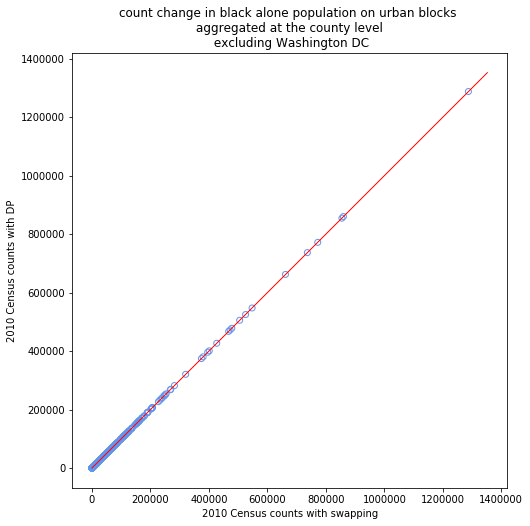

In [209]:
# 
x = urban_county_level[["P0030003_SF"]] 
y = urban_county_level[["P0030003_DP"]]

fig = plt.figure() 
fig.set_size_inches(8,8)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('2010 Census counts with swapping')
plt.ylabel('2010 Census counts with DP')
plt.title('count change in black alone population on urban blocks \n aggregated at the county level \n excluding Washington DC')

plt.show()

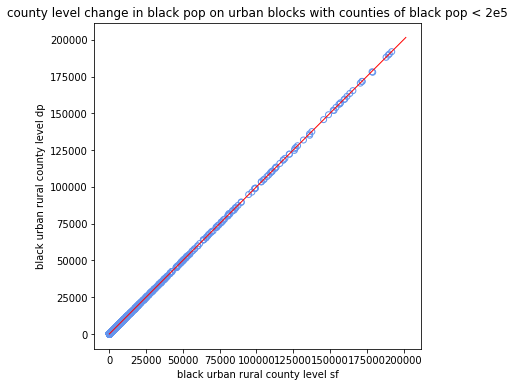

In [169]:
# 
x = urban_county_level[(urban_county_level.P0030003_SF < 2e5)][["P0030003_SF"]] 
y = urban_county_level[(urban_county_level.P0030003_SF < 2e5)][["P0030003_DP"]] 

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('black urban rural county level sf')
plt.ylabel('black urban rural county level dp')
plt.title('county level change in black pop on urban blocks with counties of black pop < 2e5')

plt.show()

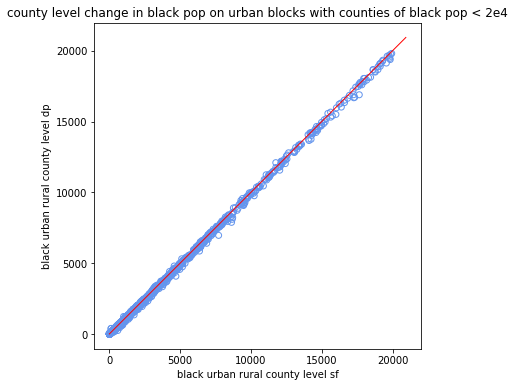

In [170]:
# 
x = urban_county_level[(urban_county_level.P0030003_SF < 2e4)][["P0030003_SF"]] 
y = urban_county_level[(urban_county_level.P0030003_SF < 2e4)][["P0030003_DP"]] 

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('black urban rural county level sf')
plt.ylabel('black urban rural county level dp')
plt.title('county level change in black pop on urban blocks with counties of black pop < 2e4')

plt.show()

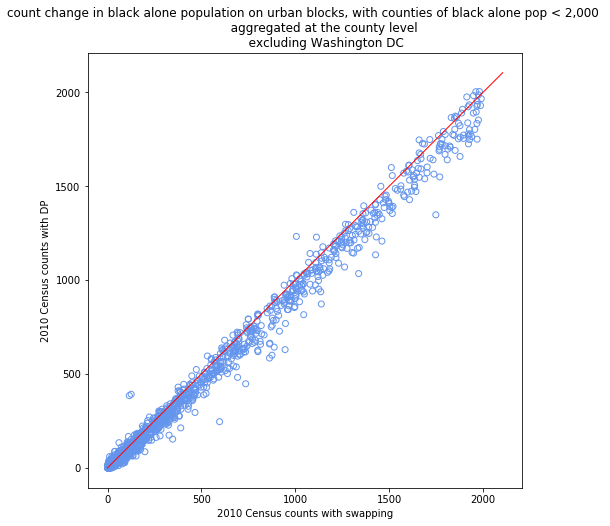

In [210]:
# 
x = urban_county_level[(urban_county_level.P0030003_SF < 2e3)][["P0030003_SF"]] #aian rural county level sf
y = urban_county_level[(urban_county_level.P0030003_SF < 2e3)][["P0030003_DP"]] #aiain rural county level dp

fig = plt.figure() 
fig.set_size_inches(8,8)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('2010 Census counts with swapping')
plt.ylabel('2010 Census counts with DP')
plt.title('count change in black alone population on urban blocks, with counties of black alone pop < 2,000 \n \
          aggregated at the county level \n \
          excluding Washington DC')

plt.show()

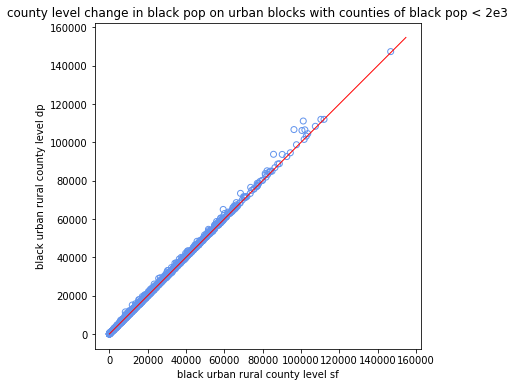

In [174]:
# 
x = rural_county_level[["P0010001_SF"]] 
y = rural_county_level[["P0010001_DP"]] 

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('county level sf')
plt.ylabel('county level dp')
plt.title('total population change at the county level for rural blocks')

plt.show()

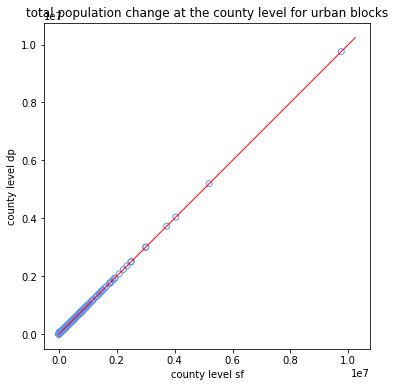

In [176]:
# 
x = urban_county_level[["P0010001_SF"]] 
y = urban_county_level[["P0010001_DP"]] 

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('county level sf')
plt.ylabel('county level dp')
plt.title('total population change at the county level for urban blocks')

plt.show()

In [16]:
# g = sns.FacetGrid(tips, col="time",  hue="smoker")
# g = (g.map(plt.scatter, "total_bill", "tip", edgecolor="w")
#       .add_legend())